In [1]:
import tensorflow as tf
import sys
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print("python版本:%s"% sys.version)

import libs.ds_layer as ds  #Dempster-Shafer layer
import libs.utility_layer_train as uti_train
import libs.utility_layer_test as uti_test #Utility layer for training
import libs.AU_imprecision as AU #Metric average utility for set-valued classification

from scipy.optimize import minimize
import math
import numpy as np

Using TensorFlow backend.


2.1.0
python版本:3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train=x_train.astype("float32") / 255.0
x_test=x_test.astype("float32") / 255.0
y_train_label = y_train
y_test_label = y_test
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [3]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=200
num_class=10

inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#convolution stages
c1_1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)

# ICS问题会影响模型的训练，而BN通过将每一层网络的输入进行标准化以及scale和shift，保证了每层输入分布的均值与方差固定在一定范围内，保留了网络的表达能力，缓解了ICS问题，使得网络能够适应更高的学习率，并大大地加速了模型的训练速度。最后，由于BN训练过程中使用的是mini-batch的均值与方差作为总体均值与方差的估计，引入了随机噪声，在一定程度上对模型起到了正则化的效果。
bt1 = layers.BatchNormalization()(c1_5)
# 池化层
p1 = layers.MaxPool2D((2,2))(bt1)
# 删除神经元，防止过度拟合
dr1 = layers.Dropout(0.5)(p1)

#convolution stages
c2_1 = layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)

# ICS问题会影响模型的训练，而BN通过将每一层网络的输入进行标准化以及scale和shift，保证了每层输入分布的均值与方差固定在一定范围内，保留了网络的表达能力，缓解了ICS问题，使得网络能够适应更高的学习率，并大大地加速了模型的训练速度。最后，由于BN训练过程中使用的是mini-batch的均值与方差作为总体均值与方差的估计，引入了随机噪声，在一定程度上对模型起到了正则化的效果。
bt2 = layers.BatchNormalization()(c2_5)
# 池化层
p2 = layers.MaxPool2D((2,2))(bt2)
# 删除神经元，防止过度拟合
dr2 = layers.Dropout(0.5)(p2)

#convolution stages
c3_1 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)

# ICS问题会影响模型的训练，而BN通过将每一层网络的输入进行标准化以及scale和shift，保证了每层输入分布的均值与方差固定在一定范围内，保留了网络的表达能力，缓解了ICS问题，使得网络能够适应更高的学习率，并大大地加速了模型的训练速度。最后，由于BN训练过程中使用的是mini-batch的均值与方差作为总体均值与方差的估计，引入了随机噪声，在一定程度上对模型起到了正则化的效果。
bt3 = layers.BatchNormalization()(c3_5)
# 池化层
p3 = layers.MaxPool2D((8,8))(bt3)
# 删除神经元，防止过度拟合
dr3 = layers.Dropout(0.5)(p3)
# 用于将输入层的数据压成一维的数据，一般用再卷积层和全连接层之间（因为全连接层只能接收一维数据，而卷积层可以处理二维数据，就是全连接层处理的是向量，而卷积层处理的是矩阵
flatten1 = layers.Flatten()(dr3)

outputs = layers.Dense(num_class, activation='softmax')(flatten1)

model_p = keras.Model(inputs=[inputs], outputs=[outputs])
model_p.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_p.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 48)        192   

In [4]:
# DS layers
ED = ds.DS1(prototypes,128)(flatten1)
ED_ac = ds.DS1_activate(prototypes)(ED)
mass_prototype = ds.DS2(prototypes, num_class)(ED_ac)
mass_prototype_omega = ds.DS2_omega(prototypes, num_class)(mass_prototype)
mass_Dempster = ds.DS3_Dempster(prototypes, num_class)(mass_prototype_omega)
mass_Dempster_normalize = ds.DS3_normalize()(mass_Dempster)

# Utility layer for training
outputs = uti_train.DM(0.9, num_class)(mass_Dempster_normalize)

model_e = keras.Model(inputs=[inputs], outputs=[outputs])
model_e.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_e.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 48)        192 

In [5]:
filepath = "C:\DLDoc\CIFAR10"
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    period=1)

# model_p.fit(x_train, y_train, batch_size=25, epochs=40, verbose=1, callbacks=[checkpoint_callback], validation_data=(x_test, y_test), shuffle=True)

In [6]:
model_p.load_weights("C:\DLDoc\CIFAR10")
#model_p.evaluate(x_train, y_train, batch_size=128, verbose=1)
model_p.evaluate(x_test, y_test, batch_size=128, verbose=1)

10000/10000 [==============================] - 3s 289us/sample - loss: 0.4564 - accuracy: 0.8649


[0.456409379196167, 0.8649]

In [7]:
# get the feature using the probabilistic classifier
model_e.load_weights("C:\DLDoc\CIFAR10")
feature = keras.Model(inputs=[inputs], outputs=[flatten1])
x_train_feature = feature.predict(x_train)
x_test_feature = feature.predict(x_test)

# use the feature to train DS layer
inputs = layers.Input(128)
ED = ds.DS1(prototypes, 128)(inputs)
ED_ac = ds.DS1_activate(prototypes)(ED)
mass_prototype = ds.DS2(prototypes, num_class)(ED_ac)
mass_prototype_omega = ds.DS2_omega(mass_prototype, num_class)(mass_prototype)
mass_Dempster = ds.DS3_Dempster(prototypes, num_class)(mass_prototype_omega)
mass_Dempster_normalize = ds.DS3_normalize()(mass_Dempster)

outputs = uti_train.DM(0.9, num_class)(mass_Dempster_normalize)

model_mid = keras.Model(inputs=[inputs], outputs=[outputs])
model_mid.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

#model_mid.fit(x_train_feature, y_train, batch_size=64, epochs=15, verbose=1, validation_data=(x_test_feature, y_test), shuffle=True)

#give the trained parameters to the evidential model
DS1_W = tf.reshape(model_mid.layers[1].get_weights()[0], [1, 200, 128])
DS1_activate_W = model_mid.layers[2].get_weights()
DS2_W = model_mid.layers[3].get_weights()

model_e.layers[26].set_weights(DS1_W)
model_e.layers[27].set_weights(DS1_activate_W)
model_e.layers[28].set_weights(DS2_W)

filepath_e = 'C:\DLDoc\model_e'
checkpoint_callback_e = ModelCheckpoint(
    filepath_e, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    period=1
)

#model_e.fit(x_train, y_train, batch_size=64, epochs=15, verbose=1, callbacks=[checkpoint_callback_e], validation_data=(x_test, y_test), shuffle=True)

In [8]:
model_e.load_weights('C:\DLDoc\model_e')
#model_e.evaluate(x_train, y_train, batch_size=128, verbose=1)
model_e.evaluate(x_test, y_test, batch_size=128, verbose=1)

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.5550 - accuracy: 0.8644


[0.5549526465415955, 0.8644]

In [9]:
# aim func: cross entropy
def func(x):
    fun=0
    for i in range(len(x)):
        fun += x[i] * math.log10(x[i])
    return fun

#constraint 1: the sum of weights is 1
def cons1(x):
    return sum(x)

#constraint 2: define tolerance to imprecision
def cons2(x):
    tol = 0
    for i in range(len(x)):
        tol += (len(x) -(i+1)) * x[i] / (len(x) - 1)
    return tol

In [10]:
#compute the weights g for ordered weighted average aggregation
num_class = 10
for j in range(2,(num_class+1)):
    num_weights = j
    ini_weights = np.asarray(np.random.rand(num_weights))

    name='weight'+str(j)
    locals()['weight'+str(j)]= np.zeros([5, j])

    for i in range(5):
        tol = 0.5 + i * 0.1

        cons = ({'type': 'eq', 'fun' : lambda x: cons1(x)-1},
                {'type': 'eq', 'fun' : lambda x: cons2(x)-tol},
                {'type': 'ineq', 'fun' : lambda x: x-0.00000001}
                )

        res = minimize(func, ini_weights, method='SLSQP', options={'disp': True}, constraints=cons)
        locals()['weight'+str(j)][i] = res.x
        print (res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3010299956639812
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.5 0.5]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2922852532386289
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.6 0.4]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2652949955741215
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.7 0.3]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.21732201127364886
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.8 0.2]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.14118174150460758
            Iter

In [11]:
#function for power set
def PowerSetsBinary(items):
    #generate all combination of N items
    N = len(items)
    #enumerate the 2**N possible combinations
    set_all=[]
    for i in range(2**N):
        combo = []
        for j in range(N):
            if(i >> j ) % 2 == 1:
                combo.append(items[j])
        set_all.append(combo)
    return set_all

In [12]:
class_set=list(range(num_class))
print(class_set)
act_set= PowerSetsBinary(class_set)
act_set.remove(act_set[0])#emptyset is not needed
act_set=sorted(act_set)
print(act_set)
print(len(act_set))  # 1023
#label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
#              5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 9], [0, 1, 2, 3, 4, 5, 6, 8], [0, 1, 2, 3, 4, 5, 6, 8, 9], [0, 1, 2, 3, 4, 5, 6, 9], [0, 1, 2, 3, 4, 5, 7], [0, 1, 2, 3, 4, 5, 7, 8], [0, 1, 2, 3, 4, 5, 7, 8, 9], [0, 1, 2, 3, 4, 5, 7, 9], [0, 1, 2, 3, 4, 5, 8], [0, 1, 2, 3, 4, 5, 8, 9], [0, 1, 2, 3, 4, 5, 9], [0, 1, 2, 3, 4, 6], [0, 1, 2, 3, 4, 6, 7], [0, 1, 2, 3, 4, 6, 7, 8], [0, 1, 2, 3, 4, 6, 7, 8, 9], [0, 1, 2, 3, 4, 6, 7, 9], [0, 1, 2, 3, 4, 6, 8], [0, 1, 2, 3, 4, 6, 8, 9], [0, 1, 2, 3, 4, 6, 9], [0, 1, 2, 3, 4, 7], [0, 1, 2, 3, 4, 7, 8], [0, 1, 2, 3, 4, 7, 8, 9], [0, 1, 2, 3, 4, 7, 9], [0, 1, 2, 3, 4, 8], [0, 1, 2, 3, 4, 8, 9], [0, 1, 2, 3, 4, 9], [0, 1, 2, 3, 5], [0, 1, 2, 3, 5, 6], [0, 1, 2, 3, 5, 6, 7], [0, 1, 2, 3, 5, 6, 7, 8], [0, 1, 2, 3, 5, 6, 7, 8, 9], [0, 1, 2, 3, 5, 6, 7, 9], [0, 1

In [13]:
utility_matrix = np.zeros([len(act_set), len(class_set)])
tol_i = 3
#tol_i = 0 with tol=0.5, tol_i = 1 with tol=0.6, tol_i = 2 with tol=0.7, tol_i = 3 with tol=0.8, tol_i = 4 with tol=0.9
for i in range(len(act_set)):
    intersec = class_set and act_set[i]
    if len(intersec) == 1:
        utility_matrix[i, intersec] = 1

    else:
        for j in range(len(intersec)):
            utility_matrix[i, intersec[j]] = locals()['weight' + str(len(intersec))][tol_i, 0]

print(utility_matrix[0:50,:])

[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.8        0.8        0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.68186243 0.68186243 0.68186243 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.59617537 0.59617537 0.59617537 0.59617537 0.         0.
  0.         0.         0.         0.        ]
 [0.53076331 0.53076331 0.53076331 0.53076331 0.53076331 0.
  0.         0.         0.         0.        ]
 [0.47818266 0.47818266 0.47818266 0.47818266 0.47818266 0.47818266
  0.         0.         0.         0.        ]
 [0.43480138 0.43480138 0.43480138 0.43480138 0.43480138 0.43480138
  0.43480138 0.         0.         0.        ]
 [0.39912197 0.39912197 0.39912197 0.39912197 0.39912197 0.39912197
  0.39912197 0.39912197 0.         0.        ]
 [0.36864039 0.36864039 0.36864039 0.36864039 0.36864039 0.36864039
  0.36864039 0.36864039 0.36864039 0.        ]
 [0.3

In [14]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=200
num_class=10
number_act_set = len(act_set)

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#convolution stages
c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)
flatten1=tf.keras.layers.Flatten()(dr3)

#DS layer
ED = ds.DS1(prototypes,128)(flatten1)
ED_ac = ds.DS1_activate(prototypes)(ED)
mass_prototypes = ds.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds.DS3_normalize()(mass_Dempster)

#Utility layer for testing
outputs = uti_test.DM_test(num_class, number_act_set, 0.9)(mass_Dempster_normalize)


model_e_imprecise = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_e_imprecise.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
model_e_imprecise.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 48)        13872     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 48)        192 

In [15]:
model_e_imprecise.layers[-1].set_weights(tf.reshape(utility_matrix, [1, 1023, 10]))
model_e_imprecise.load_weights('C:\DLDoc\model_e')

In [18]:
# 概率最大的子集的index，也就是幂集的行号
results = tf.argmax(model_e_imprecise.predict(x_test), -1)
print(results)

tf.Tensor([ 896 1020 1020 ...  992  512 1016], shape=(10000,), dtype=int64)


In [22]:
imprecise_results = []
for i in range(len(results)):
    act_index = results[i]
    set_value_results = act_set[act_index]
    imprecise_results.append(set_value_results)

print(imprecise_results)

[[3], [8], [8], [0], [6], [6], [1], [6], [3], [1], [0], [9], [5], [7], [9], [8], [5], [7], [8], [6], [7], [0, 2], [0], [9], [5, 7], [2], [4], [0], [9], [6], [6], [5], [2], [5], [9], [8], [4], [9], [9], [5], [4], [6], [5], [6], [0], [9], [3], [9], [7], [6], [9], [8], [7], [3], [8], [8], [7], [3, 5], [3, 5, 6], [3], [7], [5], [6], [3, 5], [3, 6], [2], [1], [2], [3], [7], [0, 2], [6], [8], [8], [0], [2], [9], [3], [3, 5], [8], [8], [1], [1], [7], [2], [5], [2], [7], [8], [9], [0], [3], [8], [6], [4], [6], [6], [0], [0], [7], [7], [5], [6], [3], [1], [1], [3], [6], [8], [7], [4], [0], [2, 6], [2], [1], [3], [0], [4], [6], [7], [8], [3], [1], [2], [8], [0, 2], [8], [3], [3, 6], [2], [4], [1], [8], [9], [1], [2], [9], [7], [2], [8], [6], [5], [6], [3, 7], [8], [2], [6], [5], [5], [2], [8], [9], [6], [0], [0], [5], [2], [9], [3], [4], [0, 2], [1], [6], [6], [0, 8], [4], [8], [4], [5], [0, 8], [9], [9], [9], [8], [9], [9], [3], [7], [3, 5], [0], [0], [5], [2], [2], [3], [8], [6], [3], [3], [0]

In [23]:
# 正确率
average_utility_imprecision = AU.average_utility(utility_matrix, results, y_test_label, act_set)
print(average_utility_imprecision)

[0.87990288]


label: [0]
prediciton: [0, 2]


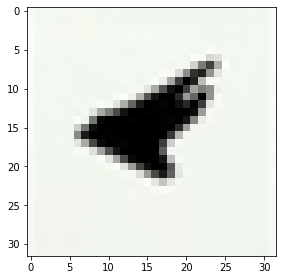

label: [5]
prediciton: [5, 7]


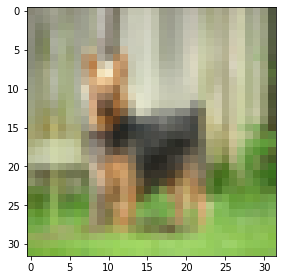

label: [6]
prediciton: [6]


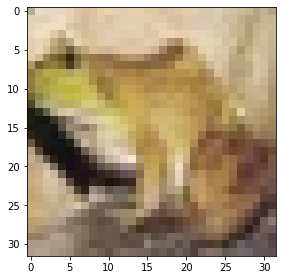

In [41]:
#label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
#              5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

imshow(x_test[21])
print('label:', y_test_label[21])
print('prediciton:', imprecise_results[21])
plt.show()

imshow(x_test[24])
print('label:', y_test_label[24])
print('prediciton:', imprecise_results[24])
plt.show()

imshow(x_test[7777])
print('label:', y_test_label[7777])
print('prediciton:', imprecise_results[7777])
plt.show()